# Poisoning Attack against SVM

In this tutorial, we will create poisoned data, which declines the performance of the model when the poisoned data is injected into the training dataset.

In [2]:
import os
import time
import copy
import random
from tqdm import tqdm

import numpy as np

import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from aijack.attack import Poison_attack_sklearn

In [3]:
np.random.seed(77)
random.seed(77)

## Prepare Dataset

In [4]:
mnist = datasets.fetch_openml("mnist_784", version=1, data_home=".", return_X_y=True)
imagedata, labeldata = mnist[0].values, mnist[1].values

index_3 = [i for i, x in enumerate(labeldata) if x == "3"]
index_7 = [i for i, x in enumerate(labeldata) if x == "7"]
image_data_3_7 = imagedata[index_3 + index_7]
label_data_3_7 = labeldata[index_3 + index_7]

(
    imagedata_training,
    imagedata_validation,
    labeldata_training,
    labeldata_validation,
) = train_test_split(image_data_3_7, label_data_3_7, test_size=0.2, shuffle=True)

imagedata_training = imagedata_training / 255.0
imagedata_validation = imagedata_validation / 255.0

X_train = imagedata_training[:5000]
y_train = labeldata_training[:5000]
X_valid = imagedata_validation[:500]
y_valid = labeldata_validation[:500]

## Train the target classification model

In [5]:
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

predict = clf.predict(X_valid)

ac_score = metrics.accuracy_score(y_valid, predict)
cl_report = metrics.classification_report(y_valid, predict)
print(cl_report)

              precision    recall  f1-score   support

           3       0.99      0.97      0.98       229
           7       0.98      0.99      0.99       271

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



## Poisoning Attack

We pick one training image and add poisoning noise to it.

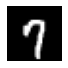

In [6]:
# initial point
initial_idx = np.where(y_train == "7")[0][42]
xc = copy.deepcopy(X_train[initial_idx, :])
yc = y_train[initial_idx]

train_idx = random.sample(list(range(1, X_train.shape[0])), 100)
X_train_ = copy.copy(X_train[train_idx, :])
y_train_ = copy.copy(y_train[train_idx])
y_train_ = np.where(y_train_ == "7", 1, -1)
y_valid_ = np.where(y_valid == "7", 1, -1)

plt.figure(figsize=(1, 1))
plt.imshow(xc.reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

You can execute poison attack with only one line.

In [7]:
attacker = Poison_attack_sklearn(clf, X_train_, y_train_, t=0.5)
xc_attacked, log = attacker.attack(xc, 1, X_valid, y_valid_, num_iterations=200)

100%|██████████| 200/200 [00:06<00:00, 32.59it/s]


The noised image looks as follows.

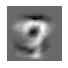

In [8]:
plt.figure(figsize=(1, 1))
plt.imshow(xc_attacked.reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

## Performance of Pisoned Model

You can see that adding only one poisoned example to 6000 training images dramatically decreases the accuracy of the model.

In [9]:
clf = SVC(kernel="linear", C=1)
clf.fit(X_train_, y_train_)
print("before attack: ", clf.score(X_valid, y_valid_))

# add poinsoned data
clf = SVC(kernel="linear", C=1)
clf.fit(
    np.concatenate([X_train_, xc_attacked.reshape(1, -1)]),
    np.concatenate([y_train_, [-1]]),
)
print("after attack: ", clf.score(X_valid, y_valid_))

before attack:  0.956
after attack:  0.846
